In [ ]:
# for CUDA
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6
!pip install gluoncv

# set GPU
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]

In [ ]:
#for CPU
!pip install mxnet  # updating mxnet to at least v1.6
!pip install gluoncv

In [10]:
import os

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import gluoncv as gcv

from mxnet import gluon, autograd
from mxnet.gluon import nn

from mxnet.gluon.data.vision import transforms

from gluoncv import model_zoo, utils

from gluoncv.data import batchify

ctx = [mx.cpu()]

In [11]:
net = model_zoo.get_model('yolo3_darknet53_coco', pretrained=True, ctx=ctx)

base_classes = ['bowl',
                'cup',
                'banana',
                'apple',
                'sandwich',
                'orange',
                'broccoli',
                'carrot',
                'hot dog',
                'pizza',
                'donut',
                'cake',
                'bottle']

net.reset_class(classes=base_classes, reuse_weights=base_classes)

In [15]:
params_path = '../trained_parameters/'
symbol_file = os.path.join(params_path, 'ResNet50_v2_epochs50-lr0.001-wd0.001-symbol.json')
params_file = os.path.join(params_path, 'ResNet50_v2_epochs50-lr0.001-wd0.001-0000.params')

test_images_folder = '../test_images/'

food_classes = ['borscht', 'lagman', 'manty', 'plov', 'samsy']

all_classes = base_classes + food_classes

food_net = nn.SymbolBlock.imports(symbol_file, ['data'], params_file, ctx=ctx)

/home/arstan/miniconda3/envs/gluoncv/lib/python3.8/site-packages/mxnet/gluon/block.py:1389: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [13]:
transform_fn = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [14]:
im_address = 'https://cdn.segodnya.ua/i/image_650x/media/image/5d9/c90/e8a/5d9c90e8a57a5.jpg'
im_fname = utils.download(im_address, path='../test_images/test.jpg', overwrite=True)

In [16]:
im_fname = 'test0.jpg'
im_fname = os.path.join(test_images_folder, im_fname)

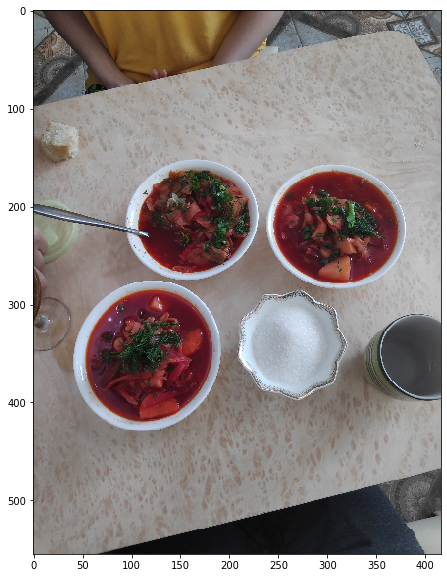

In [17]:
x, orig_img = gcv.data.transforms.presets.yolo.load_test(im_fname)

utils.viz.plot_image(orig_img)

fig = plt.gcf()
fig.set_size_inches(15, 10)

In [ ]:
# copy data to GPU if it is used
x = x.copyto(ctx[0])

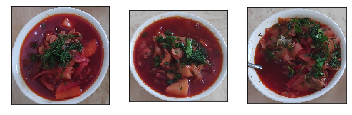

In [18]:
box_ids, scores, bboxes = net.forward(x)

box_ids_np, scores_np, bboxes_np = box_ids[0].asnumpy(), scores[0].asnumpy(), bboxes[0].asnumpy()

bowl_mask = ((box_ids_np == 0) & (scores_np > 0.5))

bowl_ids = np.where(bowl_mask)

bowl_boxes = bboxes_np[bowl_mask.ravel(), :]

if (len(bowl_boxes) == 0):
    x = x.copyto(ctx[0])
    box_ids, scores, bboxes = net.forward(x)

    ax = utils.viz.plot_bbox(orig_img, 
                             bboxes[0], 
                             scores[0], 
                             box_ids[0], 
                             class_names=base_classes, 
                             thresh=0.4)
    
    fig = plt.gcf()
    fig.set_size_inches(15, 10)

else:
    bowl_images = [orig_img[int(box[1]) : int(box[3]), int(box[0]) : int(box[2])] for box in bowl_boxes.tolist()]

    if (len(bowl_images) > 1):
        rows = len(bowl_images) // 10 + 1
        cols = len(bowl_images) % 10
        show_images(bowl_images, rows, cols, scale=2);

    bowl_batch_img = batchify.Stack()([transform_fn(mx.nd.array(img)) for img in bowl_images]).copyto(ctx[0])

    food_outputs = mx.nd.softmax(food_net(bowl_batch_img))

    food_scores = food_outputs.max(axis=1)

    food_labels = food_outputs.argmax(axis=1) + len(base_classes)

    all_classes = base_classes + food_classes

    box_ids = mx.nd.array(np.delete(box_ids_np, bowl_ids[0], axis=0)).copyto(ctx[0])
    scores = mx.nd.array(np.delete(scores_np, bowl_ids[0], axis=0)).copyto(ctx[0])
    bboxes = mx.nd.array(np.delete(bboxes_np, bowl_ids[0], axis=0)).copyto(ctx[0])

    bowl_boxes = mx.nd.array(bowl_boxes).copyto(ctx[0])

    box_ids = mx.nd.concat(box_ids, food_labels.reshape(-1, 1), dim=0)
    scores = mx.nd.concat(scores, food_scores.reshape(-1, 1), dim=0)
    bboxes = mx.nd.concat(bboxes, bowl_boxes.reshape(-1, 4), dim=0)

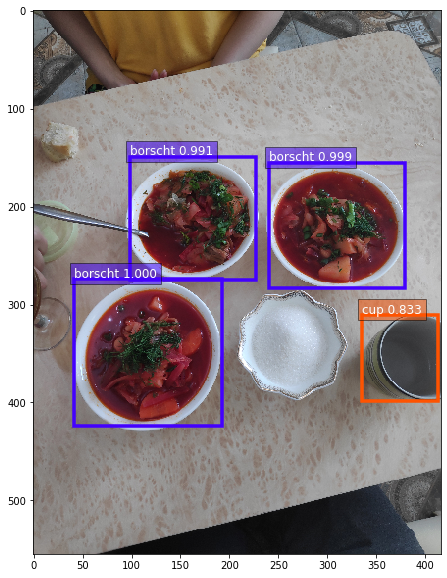

In [19]:
if (len(bowl_boxes) >= 1):

    utils.viz.plot_bbox(orig_img,
                        bboxes,
                        scores,
                        box_ids,
                        class_names=all_classes)

    fig = plt.gcf()
    fig.set_size_inches(15, 10)